In [1]:
%matplotlib inline

In [2]:
import tensorflow as tf
import numpy as np
import menpo.io as mio

from data_provider import caffe_preprocess
from menpo.image import Image
from utils_3d import crop_face

### Aux functions

In [3]:
def caffe_preprocess(image):
    VGG_MEAN = np.array([102.9801, 115.9465, 122.7717])
    # RGB -> BGR
    image = image[..., ::-1]
    # Subtract VGG training mean across all channels
    image = image - VGG_MEAN.reshape([1, 1, 3])
    return image

### Setup placeholders

In [4]:
image = tf.placeholder(tf.float32, shape=(None, None, 3), name='images')

### Load pretrained model

In [5]:
MODEL_PATH = './densereg_frozen.pb'

with open(MODEL_PATH, 'rb') as f:
    graph_def = tf.GraphDef.FromString(f.read())
    pred,  = tf.import_graph_def(graph_def,
                                 input_map={"input": image},
                                 return_elements=['prediction:0'])

### Init sesssion

In [6]:
config = tf.ConfigProto(device_count = {'GPU': 0})
sess = tf.Session(config=config)

### Import image

/vol/atlas/homes/gt108/Projects/menpo/menpo/shape/pointcloud.py:260: MenpoDeprecationWarning: The .lms property is deprecated. LandmarkGroups are now shapes themselves - so you can use them directly anywhere you previously used .lms.Simply remove ".lms" from your code and things will work as expected (and this warning will go away)
  MenpoDeprecationWarning)


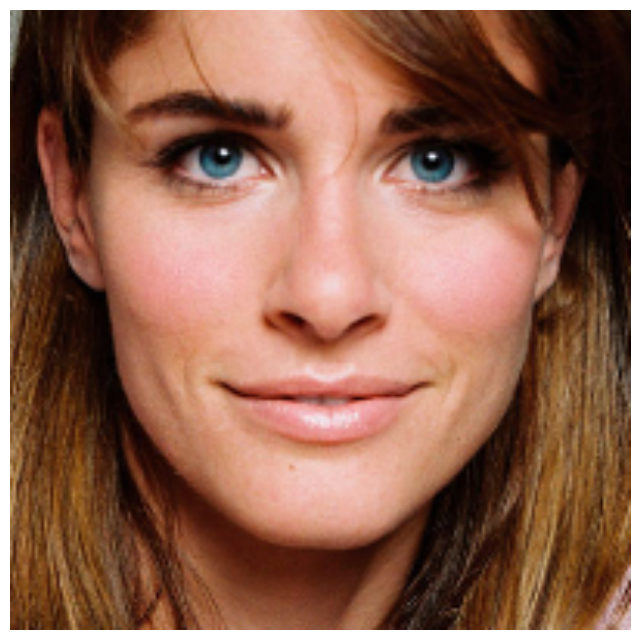

In [7]:
im = mio.import_images('/vol/atlas/databases/lfpw/trainset/')[22]
im = crop_face(im, shape=(200, 200))
im.view()

In [26]:
preprocessed = caffe_preprocess(im.pixels_with_channels_at_back() * 255) 
result = sess.run(pred, feed_dict={image: preprocessed})

In [27]:
result.shape

(1, 200, 200, 2)

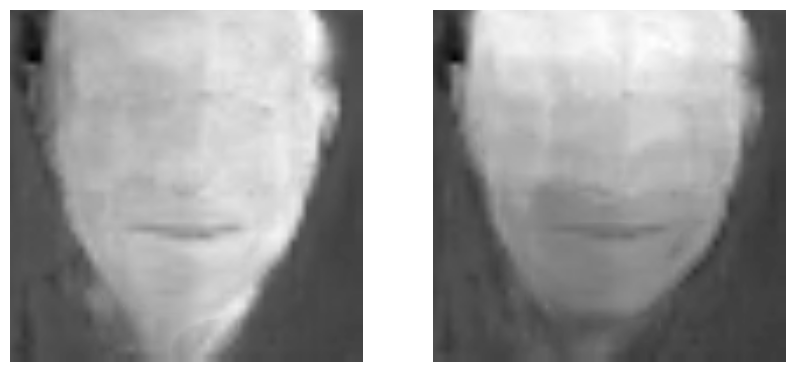

In [28]:
Image.init_from_channels_at_back(result[0]).view(channels='all')

In [11]:
import scipy.io as sio
import cv2

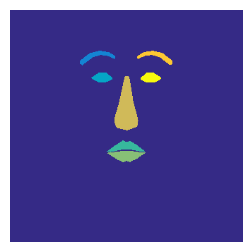

In [12]:
grid = sio.loadmat('./Grid_color.mat')['Grid_color']
grid = sio.loadmat('./SegLabelsColor.mat')['L_color']
Image.init_from_channels_at_back(grid).view(figure_size=(3, 3))

In [13]:
np.unique(np.clip(result * 10, 0, 100).astype(int))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [14]:
grid.shape

(330, 330, 3)

In [15]:
import data_provider

provider = data_provider.Dataset300W()
images, gt, _ = provider.get()
tf.train.start_queue_runners(sess)

In [48]:
preprocessed = sess.run(tf.image.resize_nearest_neighbor(images, (200, 200)))[:1]

In [49]:
result = sess.run(pred, feed_dict={image: preprocessed[0]})

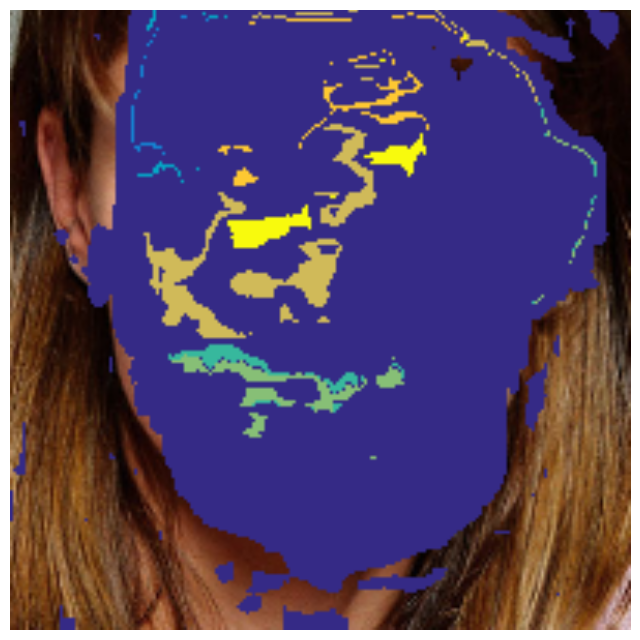

In [50]:
w, h, _ = grid.shape
H = result[0, ..., 0] * w
V = h - result[0, ..., 1] * h

grid_interpolated = cv2.remap(
    grid , H, V, 
    interpolation=cv2.INTER_NEAREST,
    borderMode=cv2.BORDER_CONSTANT,
    borderValue=(0))

grid_interpolated[grid_interpolated==0] = im.pixels_with_channels_at_back()[grid_interpolated==0]
Image.init_from_channels_at_back(grid_interpolated).view()